## Начало

Датасет: https://www.kaggle.com/cactus3/basicshapes

In [1]:
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

import csv

# модули библиотеки PyTorch
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from skimage import io
# метрика качества 
from sklearn.metrics import accuracy_score

Так как используется датасет без готового файла csv, его нужно создать:

In [2]:
header = ['file', 'figure']

with open('kurs/data.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    for i in range(1,101):
        data = ['circles/drawing('+str(i)+').png', 0 ]
        writer.writerow(data)
        data = ['squares/drawing('+str(i)+').png', 1 ]
        writer.writerow(data)
        data = ['triangles/drawing('+str(i)+').png', 2 ]
        writer.writerow(data)

Подговтовка датасета для pytorch

In [3]:
class DatasetParser():
    def __init__(self, csv_file, root_dir, transform=None):
        self.annonations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annonations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annonations.iloc[index,0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annonations.iloc[index,1]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

dataset = DatasetParser(csv_file='kurs/data.csv', root_dir='kurs', transform=transforms.ToTensor() )# <class '__main__.DatasetParser'>

train_set, test_set = torch.utils.data.random_split(dataset, [250,50])# получаем 2 рандомно составлнных сета итерированием объекта DatasetParser. Возвращент:<class 'torch.utils.data.dataset.Subset'>

train_loader = DataLoader(dataset=train_set, batch_size=25, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=len(test_set), shuffle=False)

print(type(test_set))

dataiter = iter(train_loader)

# батч картинок и батч ответов к картинкам
images, labels = dataiter.next()

images.shape, labels.shape

<class 'torch.utils.data.dataset.Subset'>


(torch.Size([25, 3, 28, 28]), torch.Size([25]))

Рисовалка:

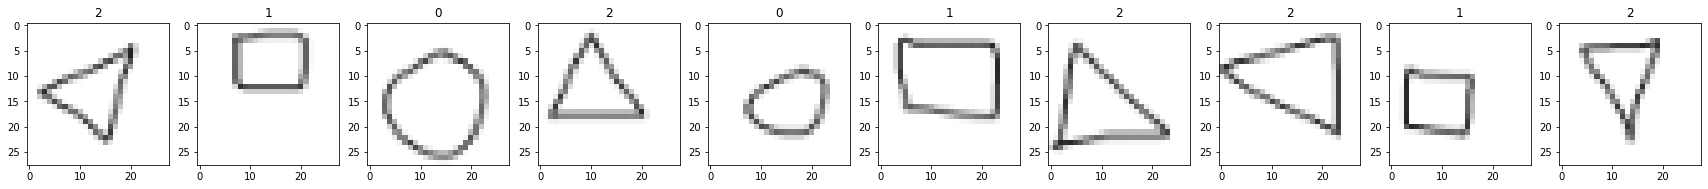

In [4]:
def show_imgs(imgs, labels):
  
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
      axes[i].imshow(np.transpose(imgs[i].numpy(), (1, 2, 0)), cmap='gray') #Транспонируем картинку в [28,28,3]
      axes[i].set_title(labels[i].numpy())
    plt.show()

def show_epoch(n_epoch, loss_epoch, color):

  if math.sqrt(n_epoch) > int(math.sqrt(n_epoch)):
    n_epoch = int(math.sqrt(n_epoch+1))
  else:
    n_epoch = int(math.sqrt(n_epoch))

  counter = 0
  f, ax= plt.subplots(n_epoch, n_epoch, sharex='col', sharey='row',figsize=(3*n_epoch,3*n_epoch))
  for i in range(n_epoch):
    for j in range(n_epoch):
      if counter<len(loss_epoch):
        ax[i,j].plot(loss_epoch[counter],color)
        counter += 1
        ax[i,j].set_title(counter)
  plt.show()

show_imgs(images, labels)

## Сверточная нейронная сеть

#TODO Вывести рамерности, веса etc

In [5]:
# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активайии для слоев нейронных сетей
import torch.nn.functional as F

In [6]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
  def forward(self, input):
    return input.view(input.size(0), -1)#пример одной картинки - [3,28,28] -> [конкатенация листов в тензоре]

class SimpleNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = Flatten()
    self.drop = nn.Dropout(p=0.5)
    self.mp = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv1 = nn.Conv2d(3, 12, kernel_size=4,stride=2)
    self.conv2 = nn.Conv2d(12, 20, kernel_size=3,padding=2)
    self.conv3 = nn.Conv2d(20, 40, kernel_size=3,padding=1)

    self.fc1 = nn.Linear(160, 170)
    self.fc2 = nn.Linear(170, 170)
    self.fc3 = nn.Linear(170, 3)

  def forward(self, x):
    # forward pass сети

    # переводим входной объект из картинки в вектор
    # применение слоев и батч нормов по очереди:
    x = F.relu(self.conv1(x))
    x = self.mp(x)
    x = F.relu(self.conv2(x))
    x = self.mp(x)
    x = F.relu(self.conv3(x))
    x = self.mp(x)
    
    x = self.flatten(x)

    x = F.relu(self.fc1(x))
    x = self.drop(x)
    x = F.relu(self.fc2(x))
    x = self.drop(x)
    x = F.softmax(self.fc3(x))

    return x

def train(net, n_epoch=40):
  # выбираем функцию потерь
  loss_fn = torch.nn.CrossEntropyLoss()
  loss_mass = []
  loss_mass_test = []
  loss_epoch = []
  loss_epoch_test = []

  # выбираем алгоритм оптимизации и learning_rate
  learning_rate = 1e-3
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

  test_dataiter = iter(test_loader)
  X_batch_test, y_batch_test = test_dataiter.next()

  for epoch in tqdm_notebook(range(n_epoch)):

    running_loss = 0.0
    train_dataiter = iter(train_loader)

    loss_local = []
    loss_local_test = []
    for i, batch in enumerate(train_dataiter):
      # так получаем текущий батч
      X_batch, y_batch = batch
      
      # обнуляем веса
      optimizer.zero_grad()
      
      # forward pass (получение ответов на батч картинок)
      y_pred = net(X_batch)
      y_pred_test = net(X_batch_test)
      # вычисление лосса от выданных сетью ответов и правильных ответов на батч
      loss = loss_fn(y_pred, y_batch)
      loss_test = loss_fn(y_pred_test,y_batch_test)
      # bsckpropagation (вычисление градиентов)
      loss.backward()
      # обновление весов сети
      optimizer.step()

      # выведем текущий loss
      running_loss += loss.item()
      
      loss_mass.append(float(loss.item()))
      loss_mass_test.append(float(loss_test.item()))

      loss_local.append(float(loss.item()))
      loss_local_test.append(float(loss_test.item()))

      #print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss))
      running_loss = 0.0
      
    loss_epoch.append(loss_local)
    loss_epoch_test.append(loss_local_test)
    
  plt.title('Loss')
  plt.plot(loss_mass)
  plt.plot(loss_mass_test)
  plt.legend(['Train set','Test set'])
  plt.show()
  
  #show_epoch(n_epoch,loss_epoch,'b')# graph_x, graph_y, loss_epoch- list of a lists of loss
  #show_epoch(n_epoch,loss_epoch_test,'orange')

  print('Обучение закончено')
  return net

In [7]:
net = SimpleNN()
net.load_state_dict(torch.load('kurs/save.state'))
#net = train(net)

<All keys matched successfully>

In [8]:
#torch.save(net.state_dict(),'save.state')

In [9]:
print(net.state_dict()['conv2.weight'].shape)

torch.Size([20, 12, 3, 3])


1.0


C:\Users\Nigel\AppData\Local\Temp/ipykernel_11476/405106806.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))
C:\Users\Nigel\AppData\Local\Temp/ipykernel_11476/405106806.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


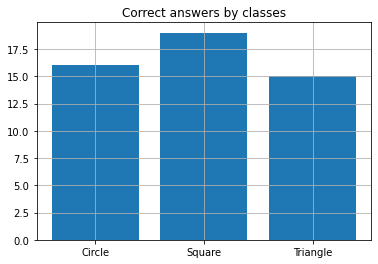

In [13]:
test_dataiter = iter(test_loader)
images, labels = test_dataiter.next()
print(accuracy_score(labels.numpy(), np.argmax(net.forward(images).detach().numpy(), axis=1)))
#print(labels.numpy())
#print(np.argmax(net.forward(images).detach().numpy(), axis=1))

#hist
true_class =[0,0,0]
for i, el in enumerate(labels.numpy()):
    if el == np.argmax(net.forward(images).detach().numpy(), axis=1)[i]:
        true_class[el]+=1
x = np.arange(3)
plt.title('Correct answers by classes')
plt.bar(x, height=true_class)
plt.xticks(x, ['Circle','Square','Triangle'])
plt.grid()

## Новое одиночное изображение

C:\Users\Nigel\AppData\Local\Temp/ipykernel_11476/405106806.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


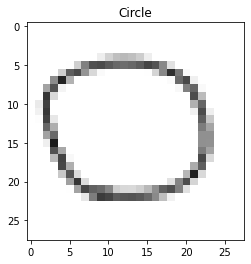

In [11]:
myimg = io.imread('kurs/drawing(1).png')
my_tens = transforms.ToTensor()

xx_image = my_tens(myimg)
yy_label = torch.tensor(int(2))

myimgSet = [(xx_image, yy_label)]

_loader2 = DataLoader(dataset=myimgSet, batch_size=1, shuffle=False)
_dataiter = iter(_loader2)
ima, lab = _dataiter.next()
num_to_name = {
    0: "Circle",
    1: "Square",
    2: "Triangle"
}
net.eval()
name = num_to_name[np.argmax(net.forward(ima).detach().numpy(), axis=1)[0]]

fig, axes = plt.subplots()
axes.set_title(name)
axes.imshow(np.transpose(ima[0].numpy(), (1, 2, 0)), cmap='gray')